In [ ]:
This notebooks code was inspired by the sample given at Neural Transfer notebook in pytorch at: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

The principle is simple: we define two distances, one for the content (DC) and one for the style (DS). DC measures how different the content is between two images while DS measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image. Now we can import the necessary packages and begin the neural transfer.

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

Now, with our imports out of the way, we need to use CUDA if it is available on this device.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Image loading code below. We pull from our image directory. Currently only 2 sample images. This could be abstracted to use other external source for the images. (A webservice, database, etc.)

In [10]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

#create our data loader
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

#image loader for a specific image
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_image = image_loader("./images/Old_guitarist.jpg")
content_image = image_loader("./images/guitarist.jpg")

style_size = style_image.size()
content_size = content_image.size()

print(f"style image size: {style_size}, content image size: {content_size}")
assert style_image.size() == content_image.size(), \
    "image sizes must match"

style image size: torch.Size([1, 3, 512, 512]), content image size: torch.Size([1, 3, 512, 512])


Now display our images to make sure they have been loaded correctly

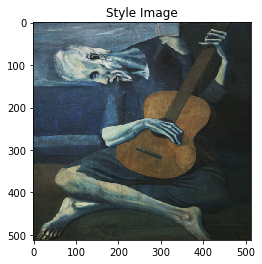

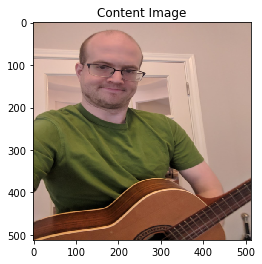

In [11]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_image, title='Style Image')

plt.figure()
imshow(content_image, title='Content Image')

Now define content loss function

In [12]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Now define style loss

In [13]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Now we are going to used a pre-trained convolutional neural network architecture - VGG19 to perform the actual training
needed to run our neural transfer algorithm.

In [14]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

We need to define a normalization method to process the input images for our VGG19 network the same as the images it has been trained on.

In our case, this means each image will have channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].

In [15]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

The final deep neural network architecture that we use is an NN.sequential combination of VGG19 and the content loss and style loss modules that we have created previously.

In [16]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

Now with our network architecture out of the way, all we have to do is stage our data and use the training loop to train the data.

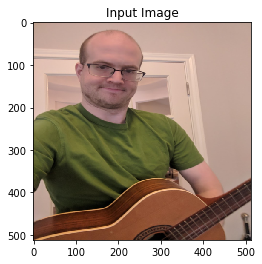

In [17]:
input_image = content_image.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_image, title='Input Image')

We are going to use an LGBFS optimizer, same as in the pytorch documentation sample.

In [18]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Now, lets run the algorithm and view our output!

Building the style transfer model..


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 40.187004 Content Loss: 5.588589

run [100]:
Style Loss : 21.507324 Content Loss: 4.210939

run [150]:
Style Loss : 13.791667 Content Loss: 3.904739

run [200]:
Style Loss : 7.932326 Content Loss: 3.906892

run [250]:
Style Loss : 4.618325 Content Loss: 3.819629

run [300]:
Style Loss : 2.650051 Content Loss: 3.670323



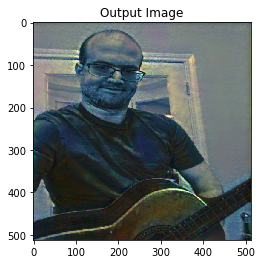

In [20]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image, input_image)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Now, we are going to try some other style images and compare to see how well this process is really working...

Building the style transfer model..


C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 35.455173 Content Loss: 11.386588

run [100]:
Style Loss : 15.190187 Content Loss: 10.679052

run [150]:
Style Loss : 8.456983 Content Loss: 9.849451

run [200]:
Style Loss : 5.186012 Content Loss: 9.064129

run [250]:
Style Loss : 3.432562 Content Loss: 8.441202

run [300]:
Style Loss : 2.145745 Content Loss: 8.045410



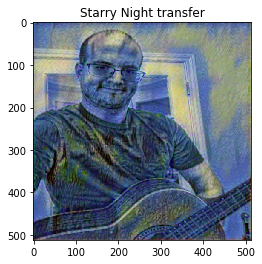

In [23]:
style_image2 = image_loader("./images/StarryNight.jpg")
style_image3 = image_loader("./images/ukiyoe.jpg")

cnn2 = models.vgg19(pretrained=True).features.to(device).eval()
output2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image2, input_image)

plt.figure()
imshow(output2, title='Starry Night transfer')
plt.ioff()
plt.show()



